In [1]:
import torch
from tqdm import tqdm

In [2]:
from hw_asr.text_encoder.ctc_char_text_encoder import CTCCharTextEncoder

text_encoder = CTCCharTextEncoder()
log_probs_length = 270
probs = torch.full((log_probs_length, len(text_encoder.char2ind)), 1 / len(text_encoder.char2ind))
for beam_size in [1, 5, 10, 20, 50, 70, 100, 120, 150]:
    print(f'{beam_size = }')
    %timeit text_encoder.ctc_beam_search(torch.log(probs), log_probs_length, beam_size=beam_size)

beam_size = 1
10 ms ± 883 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
beam_size = 5
58.2 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
beam_size = 10
110 ms ± 3.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
beam_size = 20
203 ms ± 6.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
beam_size = 50
461 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
beam_size = 70
622 ms ± 6.39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
beam_size = 100
883 ms ± 7.99 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
beam_size = 120
1.12 s ± 177 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
beam_size = 150
1.4 s ± 184 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
from hw_asr.tests.utils import clear_log_folder_after_use
from hw_asr.utils.object_loading import get_dataloaders
from hw_asr.utils.parse_config import ConfigParser


config_parser = ConfigParser.get_debug_configs()
sample_rate = config_parser.config["preprocessing"]["sr"]
with clear_log_folder_after_use(config_parser):
    dataloaders = get_dataloaders(config_parser, config_parser.get_text_encoder())

The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.


1 (0.0%) records are longer then 20.0 seconds. Excluding them.
13243 (46.4%) records are longer then 200 characters. Excluding them.
Filtered 13243(46.4%) records  from dataset
61 (2.3%) records are longer then 20.0 seconds. Excluding them.
292 (10.8%) records are longer then 200 characters. Excluding them.
Filtered 292(10.8%) records  from dataset
41 (1.4%) records are longer then 20.0 seconds. Excluding them.
201 (7.0%) records are longer then 200 characters. Excluding them.
Filtered 201(7.0%) records  from dataset


In [268]:
from hw_asr.model.deep_speech import DeepSpeech2
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath

model = DeepSpeech2(n_feats=128, n_class=28)
checkpoint = torch.load(r'saved_server\models\deep_speech_2\1024_134159\checkpoint-epoch61.pth')
model.load_state_dict(checkpoint['state_dict'])

device = torch.device('cuda:0')


def move_batch_to_device(batch):
    batch = batch.copy()
    for tensor_for_gpu in ["spectrogram", "text_encoded"]:
        batch[tensor_for_gpu] = batch[tensor_for_gpu].to(device)
    return batch


model = model.to(device)

N_BATCHES = 20
batches = []
for b in dataloaders['val-other']:
    batches.append(b)
    if len(batches) == N_BATCHES:
        break

In [269]:
with torch.no_grad():
    log_probs = []
    log_probs_length = []
    text = []
    for b in tqdm(batches):
        output = model(**move_batch_to_device(b))
        output["log_probs"] = torch.log_softmax(output["logits"], dim=-1)
        output["log_probs_length"] = model.transform_input_lengths(b["spectrogram_length"])
        for i in range(len(b['text'])):
            log_probs.append(output['log_probs'][i])
            log_probs_length.append(output['log_probs_length'][i])
            text.append(b['text'][i])






















100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


In [270]:
N_EXAMPLES = N_BATCHES * dataloaders['val-other'].batch_size

In [271]:
from hw_asr.text_encoder.ctc_char_text_encoder import CTCCharTextEncoder

text_encoder = CTCCharTextEncoder()

pred_argmax = []
for i in range(N_EXAMPLES):
    log_prob_vec = torch.argmax(log_probs[i].cpu(), dim=-1).numpy()
    pred_text = text_encoder.ctc_decode_enhanced(log_prob_vec[:log_probs_length[i]])
    pred_argmax.append(pred_text)

pred_beam_search = [text_encoder.ctc_beam_search(log_probs[i], log_probs_length[i], beam_size=5)[0].text for i in tqdm(range(N_EXAMPLES))]












































































































































































































































































































100%|██████████| 640/640 [00:53<00:00, 11.98it/s]


In [272]:
import numpy as np
from hw_asr.metric.utils import calc_cer, calc_wer


def print_wer_cer(targets, predictions):
    assert len(targets) == len(predictions)
    print(f'examples = {len(targets)}')
    wer = np.mean([calc_wer(target, prediction) for target, prediction in zip(targets, predictions)])
    cer = np.mean([calc_cer(target, prediction) for target, prediction in zip(targets, predictions)])
    print(f'WER = {wer * 100:.3f}\tCER = {cer * 100:.2f}')


print('ArgMax')
print_wer_cer(text, pred_argmax)
print('BeamSearch')
print_wer_cer(text, pred_beam_search)

ArgMax
examples = 640
WER = 33.056	CER = 12.62
BeamSearch
examples = 640
WER = 32.734	CER = 12.44


In [273]:
import gzip
import shutil
import os
from pathlib import Path
from speechbrain.utils.data_utils import download_file


def download_lm():
    url = 'https://www.openslr.org/resources/11/3-gram.pruned.1e-7.arpa.gz'
    out_directory = Path('lm_models/')
    out_directory.mkdir(exist_ok=True)
    model_path = out_directory / '3-gram.pruned.1e-7.arpa'
    if not model_path.exists():
        extract_path = out_directory / '3-gram.pruned.1e-7.arpa.gz'
        download_file(url, extract_path)
        with gzip.open(extract_path, 'rb') as f_in, open(model_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
        os.remove(str(extract_path))
        with open(model_path) as f:
            content = f.read()
        with open(model_path, 'w') as f:
            f.write(content.lower())


download_lm()

In [274]:
import arpa.models.base

lm = arpa.loadf("lm_models/3-gram.pruned.1e-7.arpa")[0]

In [342]:
from utils import reload
reload('hw_asr')

from hw_asr.text_encoder.ctc_char_text_encoder import CTCCharTextEncoder  # noqa

text_encoder = CTCCharTextEncoder()
text_encoder.lm = lm
text_encoder.alpha_len = 2.4
text_encoder.alpha_lm = 2

text_encoder.use_lm = False
EXAMPLE = 10
print(*text_encoder.ctc_beam_search(log_probs[EXAMPLE], log_probs_length[EXAMPLE], beam_size=5), sep='\n')
print()

text_encoder.use_lm = True
print(*text_encoder.ctc_beam_search(log_probs[EXAMPLE], log_probs_length[EXAMPLE], beam_size=5), sep='\n')
text[EXAMPLE]

Hypothesis(text='i did not ol i understad whem my marotivio she said', prob=4.39505187552942e-06)
Hypothesis(text='i did not ol i understad whem my maroctivio she said', prob=4.327744374469635e-06)
Hypothesis(text='i did not ol i understad whem my maotivio she said', prob=4.278617943448285e-06)
Hypothesis(text='i did not ol i understad whem my maoctivio she said', prob=4.213378469987102e-06)
Hypothesis(text='i did not ol i understad whem mym marotivio she said', prob=3.986966859477987e-06)

Hypothesis(text='i did not ol i understad whem mym maoctivio she said', prob=0.00030978413674861646)
Hypothesis(text='i did not ol i understad whem mym maotivio she said', prob=9.035877237366624e-05)
Hypothesis(text='i did not ol i understad whem mym maoctivia she said', prob=5.590307532250963e-05)
Hypothesis(text='i did not ol i understad whem mym maotivia she said', prob=5.222090708913048e-05)
Hypothesis(text='i did not ol i understad whem mym maoctivio she said', prob=1.2645778181864379e-05)


'i do not quite understand grandmamma octavia she said'

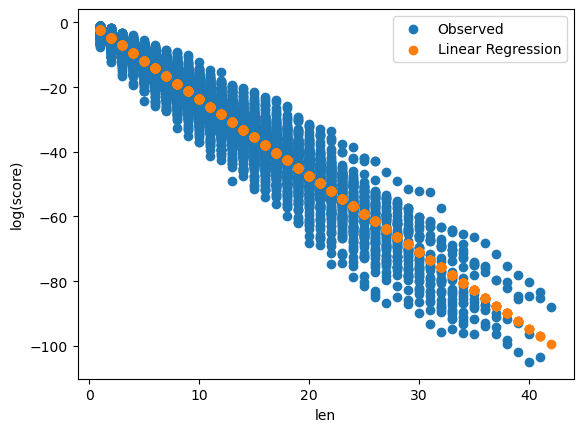

Optimal alpha_len = 2.3670717140116806


In [275]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

scores = []
lengths = []
for j in range(len(text)):
    for i in range(len(text[j].split())):
        t = ' '.join(text[j].split()[:i + 1])
        scores.append(lm.log_s(t, eos=False))
        lengths.append(len(t.split()))
scores = np.array(scores)
lengths = np.array(lengths)

model = LinearRegression(fit_intercept=False)
model.fit(lengths.reshape(-1, 1), scores)
plt.scatter(lengths, scores, label='Observed')
plt.scatter(lengths, model.predict(lengths.reshape(-1, 1)), label='Linear Regression')
plt.legend()
plt.xlabel('len')
plt.ylabel('log(score)')
plt.show()

# log(p) ~ c * len
# p ~ exp(c * len)
c = model.coef_[0]
assert c < 0
print(f'Optimal alpha_len = {abs(c)}')

In [336]:
N = N_EXAMPLES
N = 10
pred_lm = []

text_encoder.alpha_len = 2.35
text_encoder.alpha_lm = 0.5

text_encoder.use_lm = True
for i in range(N):
    print(f'{i + 1}/{N}')
    pred_lm.append(text_encoder.ctc_beam_search(log_probs[i], log_probs_length[i], beam_size=30)[0].text)

print('ArgMax')
print_wer_cer(text[:N], pred_argmax[:N])
print('BeamSearch')
print_wer_cer(text[:N], pred_beam_search[:N])
print('BeamSearch + LM')
print_wer_cer(text[:N], pred_lm[:N])

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10
ArgMax
examples = 10
WER = 33.289	CER = 12.69
BeamSearch
examples = 10
WER = 31.825	CER = 11.85
BeamSearch + LM
examples = 10
WER = 32.225	CER = 12.54


In [328]:
print_wer_cer(text[:N], [text_encoder.ctc_beam_search(log_probs[i], log_probs_length[i], beam_size=30)[0].text for i in tqdm(range(N))])

100%|██████████| 100/100 [00:27<00:00,  3.65it/s]

examples = 100
WER = 34.067	CER = 13.43


In [322]:
lm.log_s('i', eos=False) / 3

-0.37425800000000226

In [299]:
pred_beam_search[N - 1]

'but now the brandon was a ful swing'

In [297]:
pred_lm[-1]

'but now the brandon was a fuol swing'